# <a id='toc1_'></a>[Recommendation engines](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Recommendation engines](#toc1_)    
- [Collaborative filtering](#toc2_)    
  - [User-based approach](#toc2_1_)    
    - [Review movie ratings](#toc2_1_1_)    
    - [Check similar users (in 2D)](#toc2_1_2_)    
    - [Check similar users (in >2D)](#toc2_1_3_)    
      - [Compute Euclidian distances between user explicit preferences](#toc2_1_3_1_)    
      - [Convert distances into a similarity score](#toc2_1_3_2_)    
    - [Build Recommendation System For New Users](#toc2_1_4_)    
      - [Add a new user to the mix](#toc2_1_4_1_)    
      - [Recommending for Tom](#toc2_1_4_2_)    
    - [Alternative Metrics](#toc2_1_5_)    
  - [Product-based Approach](#toc2_2_)    
    - [Compute product similarity scores](#toc2_2_1_)    
    - [Build recommendation for Tom](#toc2_2_2_)    
- [Acknowledgements](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Collaborative filtering](#toc0_)

> Collaborative filtering is a series of techniques to use the reactions of users to products to inform the
> the prospective reactions of other users. There are two main paradigms:
> - **person-based recommendations:** where you expose your target to products consumed by people similar to the target > (Amazon)
> - **item-based recommendations:** where you expose your target to products similar to other products they have rated > highly in the past (Netflix)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

## <a id='toc2_1_'></a>[User-based approach](#toc0_)

### <a id='toc2_1_1_'></a>[Review movie ratings](#toc0_)

In [27]:
#The ratings.csv file shows how each of 5 people rate 10 films
ratings = pd.read_csv('https://raw.githubusercontent.com/sabinagio/data-analytics/main/data/movie_ratings.csv').set_index('Movie')
ratings

,Brandon,Emily,Cleo,Rusty,Samantha
Movie,,,,,
Top Gun: Maverick,4,1,2,2,2
Jurassic World: Dominion,2,5,2,5,5
Doctor Strange in the Multiverse of Madness,5,2,5,1,1
Sonic the Hedgehog 2,2,3,4,4,1
The Batman,3,2,4,5,1
Fantastic Beasts: The Secrets of Dumbledore,5,4,1,2,5
Uncharted,4,2,3,4,4
The Bad Guys,2,3,5,4,5
Morbius,5,5,4,3,2


> It is reasonable to assume that some people have similar preferences. Identifying these people can be a powerful lever. After all, if your friend likes the same music as you do, you go and check when they reccomend a new artist. Reccomendations from that other "friend" who likes Justin Bieber are also useful: you stay away from them as much as possible.

### <a id='toc2_1_2_'></a>[Check similar users (in 2D)](#toc0_)

In [28]:
#let's visualize how different people rate a pair of films
#this function prints a scatterplot of where the 5 people rate 2 input movies
def ratings_scatter(movie1, movie2):
    x = ratings.loc[movie1]
    y = ratings.loc[movie2]
    names = list(ratings.columns)

    plot_options, chart = plt.subplots(figsize = (6,6))
    chart.scatter(x, y, s=50)
    plt.title("Preference Space for "+ movie1 + " vs. " + movie2, fontsize=20)
    chart.set_xlabel(movie1, fontsize=16)
    chart.set_ylabel(movie2, fontsize=16)
    plt.axis([0,6,0,6])

    for i, txt in enumerate(names):
        chart.annotate(txt, (x[i], y[i]), fontsize=12)

C:\Users\sabin\AppData\Local\Temp\ipykernel_22732\3120269709.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chart.annotate(txt, (x[i], y[i]), fontsize=12)


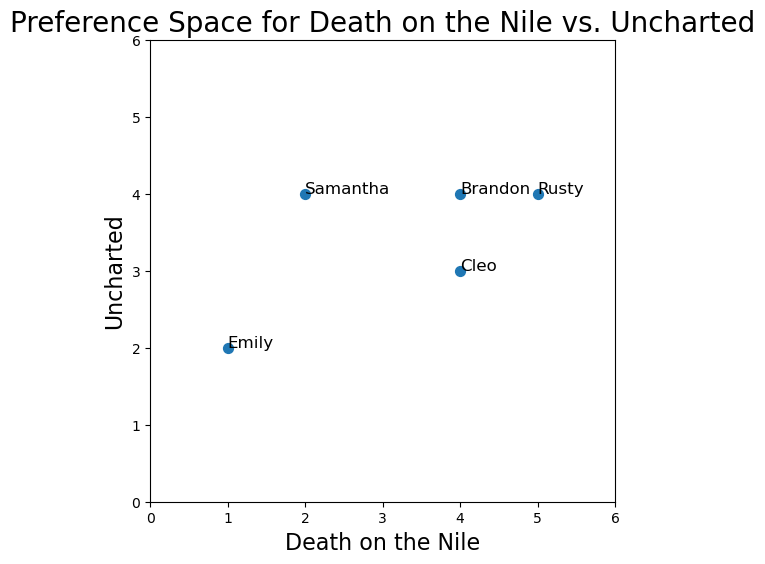

In [29]:
#We see that when it comes to Death on the Nile and the Uncharted, Rusty is "closer" to Brandon and "further" from Emily
ratings_scatter('Death on the Nile', 'Uncharted')

C:\Users\sabin\AppData\Local\Temp\ipykernel_22732\3120269709.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chart.annotate(txt, (x[i], y[i]), fontsize=12)


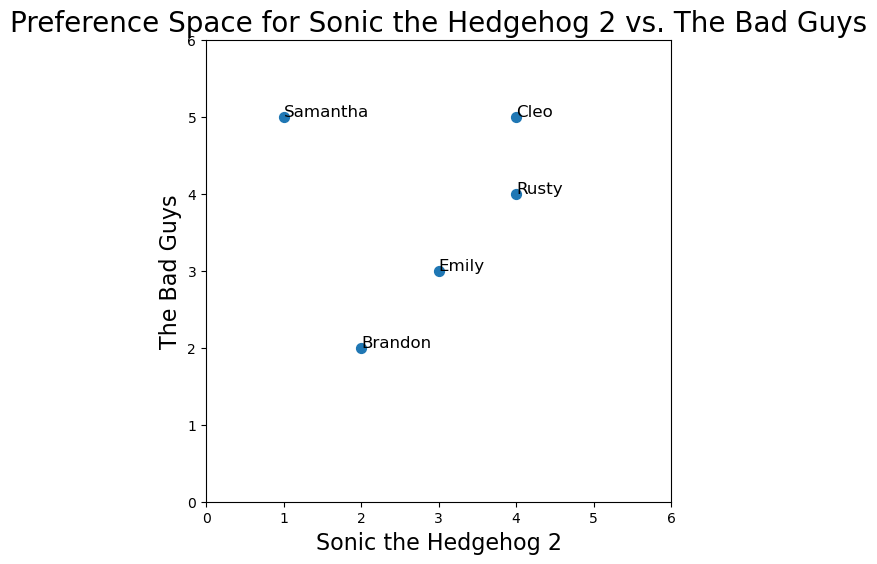

In [30]:
#but for a different pair of films, Rusty is "closer" to Emily than to Brandon
ratings_scatter('Sonic the Hedgehog 2', 'The Bad Guys')

### <a id='toc2_1_3_'></a>[Check similar users (in >2D)](#toc0_)

To extrapolate the Euclidian distance to a higher-order space, we simply extend the formula to this:

${\displaystyle d(p,q)={\sqrt {(p_{1}-q_{1})^{2}+(p_{2}-q_{2})^{2}+\cdots +(p_{n}-q_{n})^{2}}}.}$

In [31]:
# let's reshape our dataset. We want to compare individuals so let's put individuals on rows
ratings_t = ratings.transpose()
ratings_t

Movie,Top Gun: Maverick,Jurassic World: Dominion,Doctor Strange in the Multiverse of Madness,Sonic the Hedgehog 2,The Batman,Fantastic Beasts: The Secrets of Dumbledore,Uncharted,The Bad Guys,Morbius,Death on the Nile
Brandon,4,2,5,2,3,5,4,2,5,4
Emily,1,5,2,3,2,4,2,3,5,1
Cleo,2,2,5,4,4,1,3,5,4,4
Rusty,2,5,1,4,5,2,4,4,3,5
Samantha,2,5,1,1,1,5,4,5,2,2


#### <a id='toc2_1_3_1_'></a>[Compute Euclidian distances between user explicit preferences](#toc0_)

In [32]:
#scipy has a pre-build distance function, but you could easily use the one we built in normalization lesson
#we're using euclidean distance by default, which measures physical distance
import scipy.spatial.distance as dist
dist.euclidean(ratings_t.loc['Brandon'], ratings_t.loc['Emily'])

6.6332495807108

In [33]:
dist.euclidean(ratings_t.loc['Brandon'], ratings_t.loc['Rusty'])

7.416198487095663

**Who is more similar to Brandon? Emily or Rusty?**

In [34]:
#we can also do all distances between every pair of rows at once, but this output is a bit poorly formatted
dist.pdist(ratings_t)

array([6.63324958, 6.        , 7.41619849, 7.48331477, 6.92820323,
       6.40312424, 5.09901951, 5.56776436, 8.24621125, 6.70820393])

In [35]:
#fortunately scioy has yet another function to template our distances appropriately
dist.squareform(dist.pdist(ratings_t))

array([[0.        , 6.63324958, 6.        , 7.41619849, 7.48331477],
       [6.63324958, 0.        , 6.92820323, 6.40312424, 5.09901951],
       [6.        , 6.92820323, 0.        , 5.56776436, 8.24621125],
       [7.41619849, 6.40312424, 5.56776436, 0.        , 6.70820393],
       [7.48331477, 5.09901951, 8.24621125, 6.70820393, 0.        ]])

#### <a id='toc2_1_3_2_'></a>[Convert distances into a similarity score](#toc0_)

> We want to measure similarity so the big values should mean "very similar" and with euclidean distance big values mean "very far". So we make the transformation x-> (1/1 + x) to make large values into tiny ones and vice versa

In [36]:
distances = pd.DataFrame(1/(1 + dist.squareform(dist.pdist(ratings_t))),index=ratings_t.index, columns=ratings_t.index)
distances

,Brandon,Emily,Cleo,Rusty,Samantha
Brandon,1.000000,0.131006,0.142857,0.118818,0.117878
Emily,0.131006,1.000000,0.126132,0.135078,0.163961
Cleo,0.142857,0.126132,1.000000,0.152259,0.108152
Rusty,0.118818,0.135078,0.152259,1.000000,0.129732
Samantha,0.117878,0.163961,0.108152,0.129732,1.000000


> We see that Sam and Emily are somewhat closer compared to Sam and Cleo. Unsurprisingly Cleo and Emily are also not very close.

### <a id='toc2_1_4_'></a>[Build Recommendation System For New Users](#toc0_)

#### <a id='toc2_1_4_1_'></a>[Add a new user to the mix](#toc0_)

In [37]:
#now we consider Tom, who has seen the same 10 movies and rated them thusly
tom = {'Top Gun: Maverick': 2,
 'Jurassic World:  Dominion': 1,
 'Doctor Strange in the Multiverse of Madness': 5,
 'Sonic the Hedgehog 2': 5,
 'The Batman': 2,
 'Fantastic Beasts: The Secrets of Dumbledore': 3,
 'Uncharted': 3,
 'The Bad Guys': 4,
 'Morbius': 3,
 'Death on the Nile': 3}
ratings['Tom'] = pd.Series(tom)
ratings

,Brandon,Emily,Cleo,Rusty,Samantha,Tom
Movie,,,,,,
Top Gun: Maverick,4,1,2,2,2,2
Jurassic World: Dominion,2,5,2,5,5,1
Doctor Strange in the Multiverse of Madness,5,2,5,1,1,5
Sonic the Hedgehog 2,2,3,4,4,1,5
The Batman,3,2,4,5,1,2
Fantastic Beasts: The Secrets of Dumbledore,5,4,1,2,5,3
Uncharted,4,2,3,4,4,3
The Bad Guys,2,3,5,4,5,4
Morbius,5,5,4,3,2,3


How close are Tom's preferences to his friends?

In [38]:
ratings_t = ratings.transpose()
ratings_t

Movie,Top Gun: Maverick,Jurassic World: Dominion,Doctor Strange in the Multiverse of Madness,Sonic the Hedgehog 2,The Batman,Fantastic Beasts: The Secrets of Dumbledore,Uncharted,The Bad Guys,Morbius,Death on the Nile
Brandon,4,2,5,2,3,5,4,2,5,4
Emily,1,5,2,3,2,4,2,3,5,1
Cleo,2,2,5,4,4,1,3,5,4,4
Rusty,2,5,1,4,5,2,4,4,3,5
Samantha,2,5,1,1,1,5,4,5,2,2
Tom,2,1,5,5,2,3,3,4,3,3


In [39]:
distances = pd.DataFrame(1/(1 + dist.squareform(dist.pdist(ratings_t))),
                         index=ratings_t.index, columns=ratings_t.index)
distances

,Brandon,Emily,Cleo,Rusty,Samantha,Tom
Brandon,1.000000,0.131006,0.142857,0.118818,0.117878,0.156613
Emily,0.131006,1.000000,0.126132,0.135078,0.163961,0.135078
Cleo,0.142857,0.126132,1.000000,0.152259,0.108152,0.217129
Rusty,0.118818,0.135078,0.152259,1.000000,0.129732,0.126132
Samantha,0.117878,0.163961,0.108152,0.129732,1.000000,0.116961
Tom,0.156613,0.135078,0.217129,0.126132,0.116961,1.000000


In [40]:
similarity = distances.iloc[-1].sort_values(ascending=False)
similarity

Tom         1.000000
Cleo        0.217129
Brandon     0.156613
Emily       0.135078
Rusty       0.126132
Samantha    0.116961
Name: Tom, dtype: float64

#### <a id='toc2_1_4_2_'></a>[Recommending for Tom](#toc0_)

> How can we leverage this newfound knowledge about Tom's affiliation? Let's say Tom's friends also rated some other movies Tom has not seen before:

In [41]:
new_ratings = pd.read_csv('https://raw.githubusercontent.com/sabinagio/data-analytics/main/data/movie_ratings_extended.csv').set_index('Movie')
new_ratings

,Brandon,Emily,Cleo,Rusty,Samantha
Movie,,,,,
Moonfall,2,5,2,5,2
Turning Red,4,5,5,1,2
Bergen,4,1,5,4,2
Dune,4,3,3,2,5
Spider-Man: No Way Home,1,3,5,2,5
Shang-Chi and the Legend of the Ten Rings,5,4,1,2,2
Venom: Let There Be Carnage,2,1,3,3,3
Eternals,4,3,4,1,5
Free Guy,5,3,2,3,4


> What we are going to do is weight each recommendation score by the similarity to Tom. This means that Cleo's ratings will be more meaningful to Tom than Sam's. If Cleo rates movie A with a 5 and B with a 2 and Sam does the opposite, Tom is going to see movie A for sure.

In [42]:
recommendations_for_Tom = new_ratings.copy()

for name in recommendations_for_Tom.columns:
    recommendations_for_Tom[name] = recommendations_for_Tom[name] * similarity[name]
recommendations_for_Tom

,Brandon,Emily,Cleo,Rusty,Samantha
Movie,,,,,
Moonfall,0.313226,0.675391,0.434259,0.630660,0.233923
Turning Red,0.626452,0.675391,1.085646,0.126132,0.233923
Bergen,0.626452,0.135078,1.085646,0.504528,0.233923
Dune,0.626452,0.405234,0.651388,0.252264,0.584807
Spider-Man: No Way Home,0.156613,0.405234,1.085646,0.252264,0.584807
Shang-Chi and the Legend of the Ten Rings,0.783065,0.540312,0.217129,0.252264,0.233923
Venom: Let There Be Carnage,0.313226,0.135078,0.651388,0.378396,0.350884
Eternals,0.626452,0.405234,0.868517,0.126132,0.584807
Free Guy,0.783065,0.405234,0.434259,0.378396,0.467845


In [43]:
#we now add all of these wieghted scores and see what comes out on top
recommendations_for_Tom['Total'] = recommendations_for_Tom.apply(sum,axis=1)
recommendations_for_Tom.sort_values('Total', ascending=False)

,Brandon,Emily,Cleo,Rusty,Samantha,Total
Movie,,,,,,
Turning Red,0.626452,0.675391,1.085646,0.126132,0.233923,2.747544
Encanto,0.626452,0.405234,0.868517,0.378396,0.467845,2.746445
Eternals,0.626452,0.405234,0.868517,0.126132,0.584807,2.611142
Bergen,0.626452,0.135078,1.085646,0.504528,0.233923,2.585627
Dune,0.626452,0.405234,0.651388,0.252264,0.584807,2.520145
Spider-Man: No Way Home,0.156613,0.405234,1.085646,0.252264,0.584807,2.484564
Free Guy,0.783065,0.405234,0.434259,0.378396,0.467845,2.468799
Moonfall,0.313226,0.675391,0.434259,0.630660,0.233923,2.287458
Shang-Chi and the Legend of the Ten Rings,0.783065,0.540312,0.217129,0.252264,0.233923,2.026693


### <a id='toc2_1_5_'></a>[Alternative Metrics](#toc0_)

> Euclidean distance is actually fine and often used in collaborative filtering but there is no reason why a similarity metric developed to measure physical distance should be suitable to similarity in movie tastes. Cosine similarity is a kind of "correlation" that we can argue is a better metric to understand difference in taste.

In [44]:
distances = pd.DataFrame(1/(1 + dist.squareform(dist.pdist(ratings_t, 'cosine'))),
                         index=ratings_t.index, columns=ratings_t.index)

similarity = distances.iloc[-1].sort_values(ascending=False)

recommendations_for_Tom = new_ratings.copy()

for name in recommendations_for_Tom.columns:
    recommendations_for_Tom[name] = recommendations_for_Tom[name] * similarity[name]

recommendations_for_Tom['Total'] = recommendations_for_Tom.apply(sum,axis=1)
recommendations_for_Tom.sort_values('Total', ascending=False)

,Brandon,Emily,Cleo,Rusty,Samantha,Total
Movie,,,,,,
Encanto,3.615951,2.511274,3.809728,2.532334,3.168375,15.637662
Turning Red,3.615951,4.185457,4.762161,0.844111,1.584187,14.991867
Eternals,3.615951,2.511274,3.809728,0.844111,3.960468,14.741533
Free Guy,4.519939,2.511274,1.904864,2.532334,3.168375,14.636786
Dune,3.615951,2.511274,2.857296,1.688222,3.960468,14.633212
Bergen,3.615951,0.837091,4.762161,3.376445,1.584187,14.175835
Spider-Man: No Way Home,0.903988,2.511274,4.762161,1.688222,3.960468,13.826113
Moonfall,1.807976,4.185457,1.904864,4.220556,1.584187,13.703040
Shang-Chi and the Legend of the Ten Rings,4.519939,3.348365,0.952432,1.688222,1.584187,12.093146


> You see, we get slightly different results. A correct choice of metric is paramount in similarity based algorithms. Find more examples here: https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

## <a id='toc2_2_'></a>[Product-based Approach](#toc0_)

In [45]:
#we now consider a product based approach. First we take all the movies for which we have *some* ratings
ratings1 = pd.read_csv('https://raw.githubusercontent.com/sabinagio/data-analytics/main/data/movie_ratings.csv').set_index('Movie')
ratings2 = pd.read_csv('https://raw.githubusercontent.com/sabinagio/data-analytics/main/data/movie_ratings_extended.csv').set_index('Movie')
full_ratings = pd.concat([ratings1, ratings2])
full_ratings

,Brandon,Emily,Cleo,Rusty,Samantha
Movie,,,,,
Top Gun: Maverick,4,1,2,2,2
Jurassic World: Dominion,2,5,2,5,5
Doctor Strange in the Multiverse of Madness,5,2,5,1,1
Sonic the Hedgehog 2,2,3,4,4,1
The Batman,3,2,4,5,1
Fantastic Beasts: The Secrets of Dumbledore,5,4,1,2,5
Uncharted,4,2,3,4,4
The Bad Guys,2,3,5,4,5
Morbius,5,5,4,3,2


### <a id='toc2_2_1_'></a>[Compute product similarity scores](#toc0_)

In [46]:
distances = pd.DataFrame(1/(1 + dist.squareform(dist.pdist(full_ratings,'cosine'))),
                         index=full_ratings.index, columns=full_ratings.index)
distances

Movie,Top Gun: Maverick,Jurassic World: Dominion,Doctor Strange in the Multiverse of Madness,Sonic the Hedgehog 2,The Batman,Fantastic Beasts: The Secrets of Dumbledore,Uncharted,The Bad Guys,Morbius,Death on the Nile,Moonfall,Turning Red,Bergen,Dune,Spider-Man: No Way Home,Shang-Chi and the Legend of the Ten Rings,Venom: Let There Be Carnage,Eternals,Free Guy,Encanto
Movie,,,,,,,,,,,,,,,,,,,,
Top Gun: Maverick,1.000000,0.802671,0.903608,0.829187,0.870573,0.894070,0.953320,0.843741,0.907747,0.925712,0.788074,0.844171,0.925712,0.919474,0.780987,0.903248,0.897923,0.896672,0.960810,0.940874
Jurassic World: Dominion,0.802671,1.000000,0.707571,0.863230,0.832801,0.887141,0.908635,0.920691,0.861892,0.820105,0.950503,0.803564,0.792911,0.896906,0.870074,0.838361,0.887445,0.846024,0.896906,0.902306
Doctor Strange in the Multiverse of Madness,0.903608,0.707571,1.000000,0.838795,0.840932,0.777397,0.836228,0.801109,0.910811,0.855860,0.728826,0.925775,0.908652,0.839012,0.780192,0.828999,0.819371,0.868757,0.839012,0.886357
Sonic the Hedgehog 2,0.829187,0.863230,0.838795,1.000000,0.974823,0.758972,0.883695,0.905617,0.919429,0.923815,0.923815,0.875204,0.923815,0.819799,0.840994,0.800417,0.897816,0.804209,0.832477,0.900328
The Batman,0.870573,0.832801,0.840932,0.974823,1.000000,0.753073,0.907238,0.880847,0.892777,0.976665,0.887594,0.822453,0.960599,0.809370,0.794672,0.795989,0.913901,0.784207,0.844192,0.892599
Fantastic Beasts: The Secrets of Dumbledore,0.894070,0.887141,0.777397,0.758972,0.753073,1.000000,0.906220,0.834126,0.883316,0.783369,0.822200,0.835294,0.774228,0.958709,0.804229,0.943292,0.831409,0.920325,0.972652,0.913837
Uncharted,0.953320,0.908635,0.836228,0.883695,0.907238,0.906220,1.000000,0.940153,0.903446,0.946182,0.866218,0.837062,0.931845,0.953959,0.868240,0.870349,0.973956,0.915120,0.968868,0.977647
The Bad Guys,0.843741,0.920691,0.801109,0.905617,0.880847,0.834126,0.940153,1.000000,0.868132,0.886216,0.864326,0.853129,0.897582,0.927094,0.971240,0.778817,0.975189,0.915063,0.880794,0.957462
Morbius,0.907747,0.861892,0.910811,0.919429,0.892777,0.883316,0.903446,0.868132,1.000000,0.875134,0.897582,0.962805,0.886216,0.903351,0.824784,0.942292,0.858616,0.892609,0.927094,0.944933


### <a id='toc2_2_2_'></a>[Build recommendation for Tom](#toc0_)

In [47]:
tom_preferences = pd.Series(tom)
tom_preferences

Top Gun: Maverick                              2
Jurassic World:  Dominion                      1
Doctor Strange in the Multiverse of Madness    5
Sonic the Hedgehog 2                           5
The Batman                                     2
Fantastic Beasts: The Secrets of Dumbledore    3
Uncharted                                      3
The Bad Guys                                   4
Morbius                                        3
Death on the Nile                              3
dtype: int64

> The movies Tom has already seen will be used as predictors for the ones he is yet to see. We keep Tom's already seen movies in the rows and add Tom's not yet seen seen movies in the columns.

In [48]:
tom_movies = distances.loc[tom_preferences.index,distances.columns.difference(tom_preferences.index)]
tom_movies

,Bergen,Dune,Encanto,Eternals,Free Guy,Moonfall,Shang-Chi and the Legend of the Ten Rings,Spider-Man: No Way Home,Turning Red,Venom: Let There Be Carnage
Top Gun: Maverick,0.925712,0.919474,0.940874,0.896672,0.960810,0.788074,0.903248,0.780987,0.844171,0.897923
Jurassic World: Dominion,0.792911,0.896906,0.902306,0.846024,0.896906,0.950503,0.838361,0.870074,0.803564,0.887445
Doctor Strange in the Multiverse of Madness,0.908652,0.839012,0.886357,0.868757,0.839012,0.728826,0.828999,0.780192,0.925775,0.819371
Sonic the Hedgehog 2,0.923815,0.819799,0.900328,0.804209,0.832477,0.923815,0.800417,0.840994,0.875204,0.897816
The Batman,0.960599,0.809370,0.892599,0.784207,0.844192,0.887594,0.795989,0.794672,0.822453,0.913901
Fantastic Beasts: The Secrets of Dumbledore,0.774228,0.958709,0.913837,0.920325,0.972652,0.822200,0.943292,0.804229,0.835294,0.831409
Uncharted,0.931845,0.953959,0.977647,0.915120,0.968868,0.866218,0.870349,0.868240,0.837062,0.973956
The Bad Guys,0.897582,0.927094,0.957462,0.915063,0.880794,0.864326,0.778817,0.971240,0.853129,0.975189
Morbius,0.886216,0.903351,0.944933,0.892609,0.927094,0.897582,0.942292,0.824784,0.962805,0.858616
Death on the Nile,0.984127,0.844613,0.914656,0.816844,0.880303,0.837838,0.802789,0.797528,0.802315,0.946009


> We now weigh every movie Tom has seen by his own personal preference. Films that Tom rated highly (in rows) and which relate strongly to other films (columns) will contribute a higher score to that column. Films that Tom rated poorly or that don't correlate well to other films will contribute a lower score to that column.

In [49]:
for name in tom_preferences.index:
    tom_movies.loc[name] = tom_movies.loc[name]*tom_preferences[name]
tom_movies

,Bergen,Dune,Encanto,Eternals,Free Guy,Moonfall,Shang-Chi and the Legend of the Ten Rings,Spider-Man: No Way Home,Turning Red,Venom: Let There Be Carnage
Top Gun: Maverick,1.851423,1.838947,1.881748,1.793345,1.921621,1.576148,1.806495,1.561975,1.688341,1.795845
Jurassic World: Dominion,0.792911,0.896906,0.902306,0.846024,0.896906,0.950503,0.838361,0.870074,0.803564,0.887445
Doctor Strange in the Multiverse of Madness,4.543260,4.195060,4.431783,4.343785,4.195060,3.644131,4.144993,3.900961,4.628876,4.096855
Sonic the Hedgehog 2,4.619075,4.098997,4.501640,4.021044,4.162384,4.619075,4.002087,4.204970,4.376019,4.489081
The Batman,1.921198,1.618740,1.785197,1.568414,1.688384,1.775189,1.591977,1.589345,1.644907,1.827802
Fantastic Beasts: The Secrets of Dumbledore,2.322684,2.876127,2.741511,2.760975,2.917955,2.466601,2.829877,2.412687,2.505882,2.494226
Uncharted,2.795534,2.861876,2.932940,2.745360,2.906605,2.598654,2.611048,2.604719,2.511185,2.921867
The Bad Guys,3.590326,3.708375,3.829849,3.660252,3.523178,3.457304,3.115269,3.884960,3.412518,3.900756
Morbius,2.658647,2.710054,2.834798,2.677827,2.781281,2.692745,2.826875,2.474352,2.888415,2.575848
Death on the Nile,2.952381,2.533840,2.743968,2.450533,2.640909,2.513514,2.408366,2.392584,2.406946,2.838028


In [50]:
#we now compute the total score for prospective movie (in columns)
tom_movies.sum().sort_values(ascending=False)

Encanto                                      28.585740
Bergen                                       28.047439
Venom: Let There Be Carnage                  27.827754
Free Guy                                     27.634284
Dune                                         27.338922
Eternals                                     26.867559
Turning Red                                  26.866652
Moonfall                                     26.293863
Shang-Chi and the Legend of the Ten Rings    26.175349
Spider-Man: No Way Home                      25.896628
dtype: float64

# <a id='toc3_'></a>[Acknowledgements](#toc0_)

Thank you, David Henriques, for your awesome lesson structure and content.